In [19]:
!git clone https://github.com/btubay/techsummitCoEIA.git

fatal: destination path 'techsummitCoEIA' already exists and is not an empty directory.


In [20]:
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from collections import Counter

import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix

import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, concatenate
from tensorflow.keras import layers

import seaborn as sns

In [21]:
# General parameters
batch_size = 128
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)
folder_path = "techsummitCoEIA/images/"

In [22]:
# def plot_exp(expression):
#     plt.style.use('dark_background')
#     plt.figure(figsize= (12,12))
#     for i in range(1, 10, 1):
#         plt.subplot(3,3,i)
#         img = load_img(folder_path+"train/"+expression+"/"+
#                   os.listdir(folder_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
#         plt.imshow(img)   
#     plt.show()
# plot_exp('sad')

In [23]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict
    
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

In [24]:
train_dict = dict()
val_dict = dict()
walk_data(train_dict, folder_path + "train/")
walk_data(val_dict, folder_path + "validation/")
train_dict = fix_keys(train_dict)
val_dict = fix_keys(val_dict)
print(train_dict)
print(val_dict)

{'sad': 4938, 'neutral': 4982, 'happy': 7164}
{'sad': 1139, 'neutral': 1216, 'happy': 1825}


In [25]:
# label_train_dict = {'Expressions':train_dict.keys(), 'Count':train_dict.values}
# label_val_dict = {'Expressions':val_dict.keys(), 'Count':val_dict.values}

In [26]:
plot_dist(train_dict, "Training data")

In [27]:
plot_dist(val_dict, "Validation data")

In [28]:
datagen_train  = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)


train_set = datagen_train.flow_from_directory(
        folder_path+"train",
        target_size=(pic_size, pic_size),
        color_mode = "grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

test_set = datagen_val.flow_from_directory(
        folder_path+"validation",
        target_size=(pic_size, pic_size),
        color_mode = "grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

counter = Counter(train_set.classes)
labels = (train_set.class_indices)
values2labels= {v: k for k, v in labels.items()}                          
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

Found 17084 images belonging to 3 classes.
Found 4180 images belonging to 3 classes.


## Diseño de la red

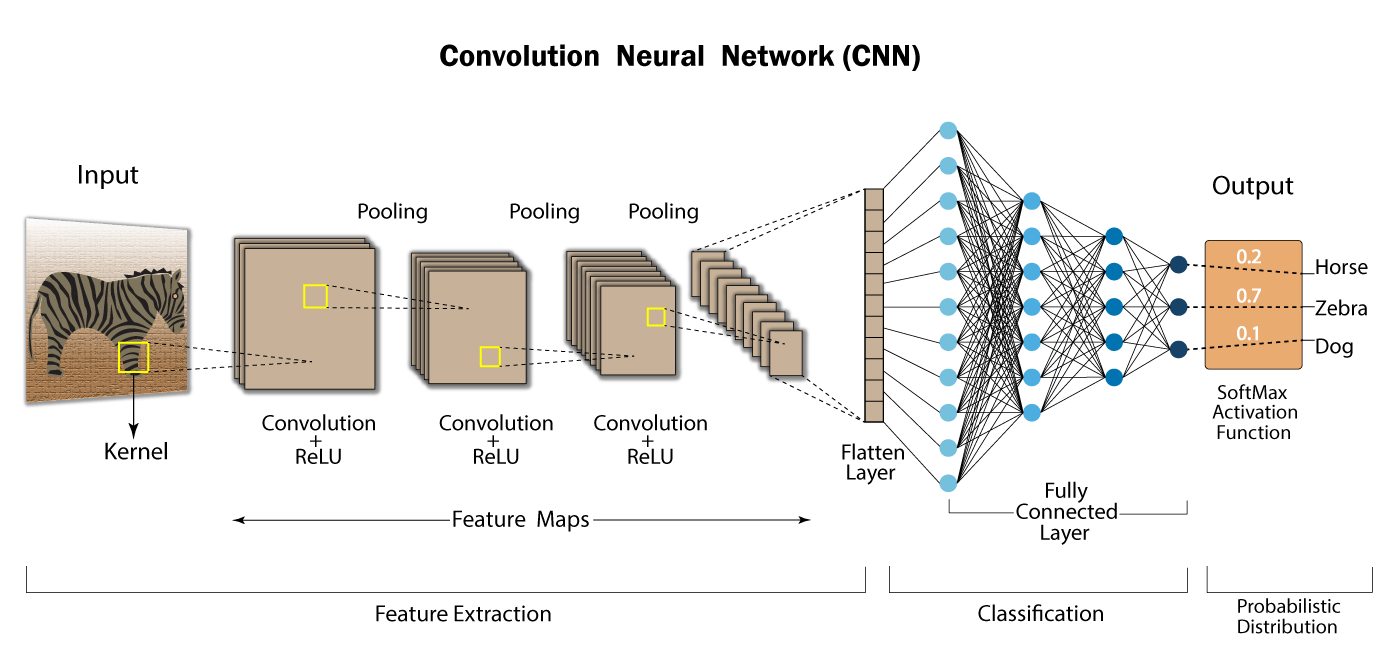

Max Pooling:

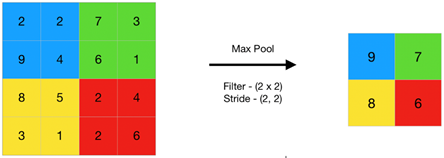

### Principios de diseño para una red neuronal convolucional:

 "*Mantener el espacio de características amplio y poco profundo en las etapas iniciales de la red, y hacerlo más estrecho y profundo hacia el final*"

1.	**Empezar** siempre utilizando **filtros más pequeños** para recoger la mayor cantidad de información local posible, y luego **aumentar gradualmente la anchura del filtro** para reducir la anchura del espacio de características generado para representar información más global, de alto nivel y representativa.
2.	Siguiendo el principio, el **número de canales debe ser bajo al principio**, de manera que detecte características de bajo nivel que se combinen para formar muchas formas complejas (aumentando el número de canales) que ayuden a distinguir entre clases.
3.	Los **tamaños generales de los filtros utilizados son 3x3, 5x5 y 7x7** para la capa convolucional para imágenes de tamaño moderado o pequeño y para los parámetros de **Max-Pooling utilizamos tamaños de filtro de 2x2 o 3x3 con un stride de 2**. Se pueden utilizar tamaños de filtro y strides más grandes para reducir una imagen grande a un tamaño moderado y luego ir más allá con la convención indicada.
4.	Utilizar el **padding = ‘same’** cuando considere que los bordes de la imagen pueden ser importantes o simplemente para ayudar a alargar la arquitectura de red, ya que el relleno mantiene las mismas dimensiones incluso después de la operación de convolución y, por lo tanto, puede realizar más convoluciones sin reducir el tamaño.
5.	**Añadir capas hasta que haya overfitting**. Ya que una vez que logramos una precisión considerable en nuestro conjunto de validación podemos utilizar componentes de regularización como la **regularización l1/l2**, el **dropout**, **batch norm**, la **data-aumentation**, etc. para reducir el overfitting.
6.	Usar **redes clásicas** como **LeNet**, **AlexNet**, **VGG-16**, **VGG-19**, etc. como inspiración al construir las arquitecturas de sus modelos. Es decir, seguir la tendencia utilizada en las arquitecturas, por ejemplo, la tendencia en las capas Conv-Pool-Conv-Pool o Conv-Conv-Pool-Conv-Conv-Pool o la tendencia en el número de canales 32-64-128 o 32-32-64-64 o la tendencia en los tamaños de los filtros, los parámetros Max-pooling, etc.


In [29]:
def model_cnn(): 

    model = Sequential()
    # Convolutional + Pooling Layers
    model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(pic_size,pic_size,1)))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),strides=2))
    model.add(Dropout(0.2))
    # Flatten Layer
    model.add(Flatten())
    # Dense Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'], loss='categorical_crossentropy')

    model.summary()
    
    return model

In [30]:
model_conv = model_cnn()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 16)        0

In [31]:
hist = model_conv.fit(train_set, 
                    validation_data = test_set,
                    epochs = 30,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    validation_steps = test_set.n//test_set.batch_size,
                    verbose=1, callbacks=[callback])
model_conv.save("ts.h5")

Epoch 1/30
133/133 [==============================] - 15s 44ms/step - loss: 1.0793 - accuracy: 0.4184 - val_loss: 1.0825 - val_accuracy: 0.4536
Epoch 2/30
133/133 [==============================] - 5s 39ms/step - loss: 1.0124 - accuracy: 0.4924 - val_loss: 0.9121 - val_accuracy: 0.5769
Epoch 3/30
133/133 [==============================] - 5s 41ms/step - loss: 0.9217 - accuracy: 0.5584 - val_loss: 0.8523 - val_accuracy: 0.6008
Epoch 4/30
133/133 [==============================] - 5s 37ms/step - loss: 0.8878 - accuracy: 0.5796 - val_loss: 0.8310 - val_accuracy: 0.6284
Epoch 5/30
133/133 [==============================] - 5s 38ms/step - loss: 0.8583 - accuracy: 0.5991 - val_loss: 0.7844 - val_accuracy: 0.6497
Epoch 6/30
133/133 [==============================] - 5s 38ms/step - loss: 0.8354 - accuracy: 0.6106 - val_loss: 0.7680 - val_accuracy: 0.6562
Epoch 7/30
133/133 [==============================] - 5s 41ms/step - loss: 0.8124 - accuracy: 0.6241 - val_loss: 0.7648 - val_accuracy: 0.657

[]

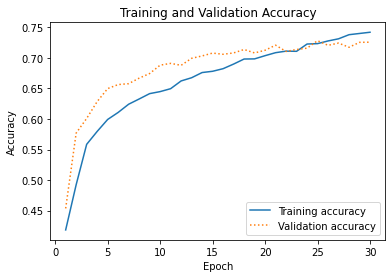

In [32]:
#Training and Validation Accuracy
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [33]:
y_predicted = model_conv.predict(test_set)
y_pred = [np.argmax(probas) for probas in y_predicted]
y_test = test_set.classes

Accuracy: 0.7229665071770335
Precision: 0.7229665493658965
F1-score: 0.7229594263578791
Recall: 0.7229665071770335



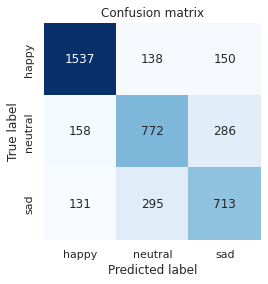

In [34]:
sns.set()

mat = confusion_matrix(y_test, y_pred)
s = sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels = ['happy', 'neutral', 'sad'], yticklabels = ['happy', 'neutral', 'sad'])
plt.title("Confusion matrix")
s.set(xlabel='Predicted label', ylabel='True label')
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred, average='weighted')))
print("F1-score: " + str(f1_score(y_test, y_pred, average='weighted')))
print("Recall: " + str(recall_score(y_test, y_pred, average='weighted')) + "\n")

In [35]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

 #load the image
my_image = load_img('techsummitCoEIA/persona_feliz.jpg', target_size=(pic_size, pic_size), color_mode="grayscale")

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
#make the prediction
prediction = model_conv.predict(my_image)
prediction

array([[0., 0., 1.]], dtype=float32)

In [36]:
values2labels[prediction.argmax()]

'sad'